In [5]:
!pip install kaggle

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vishnudarshan","key":"1d8ec5f91eb354a34e5f83e7a2d63912"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle competitions download -c dogs-vs-cats

 98% 265M/271M [00:04<00:00, 67.2MB/s]
100% 271M/271M [00:04<00:00, 58.3MB/s]
100% 541M/543M [00:06<00:00, 85.6MB/s]
100% 543M/543M [00:06<00:00, 85.8MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 81.8MB/s]


In [11]:
from zipfile import ZipFile
file_name = "train.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [12]:
from zipfile import ZipFile
file_name = "test.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
import numpy as np
import pandas as pd
import tensorflow as  tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,BatchNormalization,Activation,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import os

# Preparing Training Data

In [0]:
filenames = os.listdir("/content/train")
categories = []
for filename in filenames:
  category = filename.split('.')[0]
  if category == "dog":
    categories.append(1)
  else:
    categories.append(0)

df = pd.DataFrame({
    'filename' : filenames,
    'category':categories
})

In [113]:
df.head()
#Here we will encode the dog as 1 and cat as 0

,filename,category
0,cat.3930.jpg,0
1,dog.6800.jpg,1
2,dog.6749.jpg,1
3,dog.6589.jpg,1
4,dog.5597.jpg,1


# Sample Image

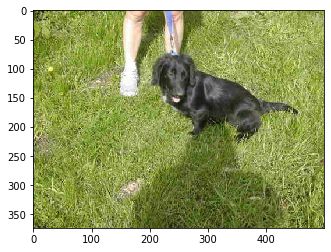

In [15]:
sample = random.choice(filenames)
image = load_img("/content/train/"+sample)
plt.imshow(image)

# Prepare Data

Because we will use image generetor with class_mode="categorical". We need to convert column category into string. Then image generator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat


In [0]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})

# Build a Model

![alt text](https://i.imgur.com/ebkMGGu.jpg)

In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128,128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()




Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________

# Prepare Data

In [0]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True) # rest the index
validate_df = validate_df.reset_index(drop=True)

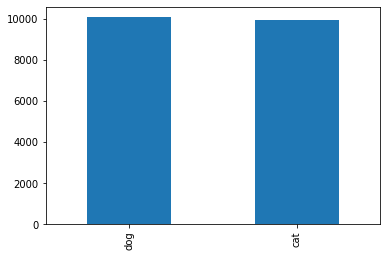

In [20]:
train_df['category'].value_counts().plot.bar()

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15
image_size = (128,128)

# Training Generator

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=image_size,
    class_mode='categorical',
    batch_size=15

)


Found 20000 validated image filenames belonging to 2 classes.


# Validation Generator

In [23]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# Check our Generator

In [24]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=image_size,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


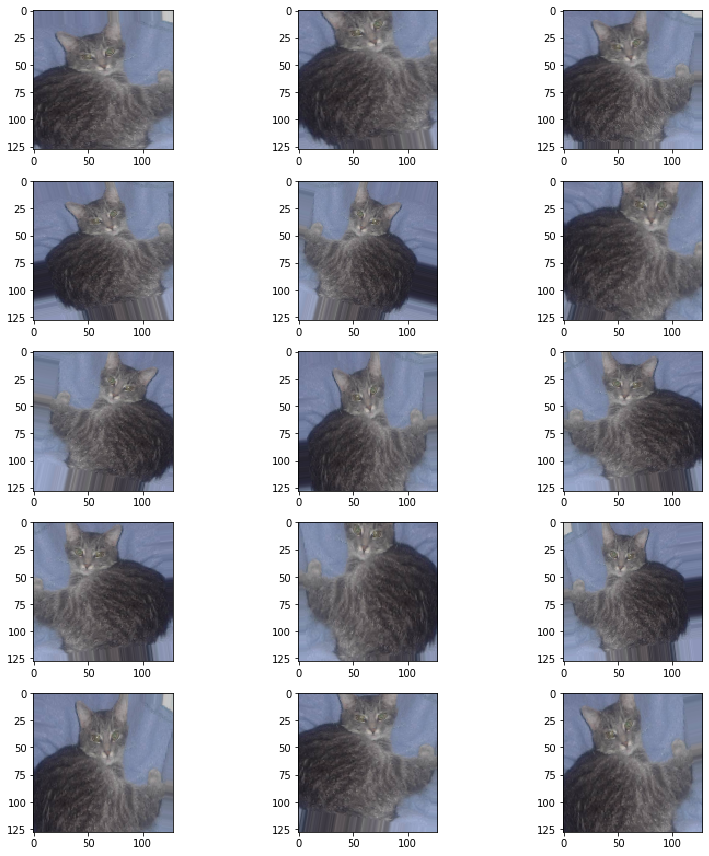

In [25]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Fit Model 

In [26]:
history = model.fit_generator(
    train_generator, 
    epochs=3,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,

)

Epoch 1/3
1333/1333 [==============================] - 184s 138ms/step - loss: 0.7620 - acc: 0.6275 - val_loss: 0.5839 - val_acc: 0.6929
Epoch 2/3
1333/1333 [==============================] - 179s 134ms/step - loss: 0.5771 - acc: 0.7117 - val_loss: 0.5126 - val_acc: 0.7471
Epoch 3/3
1333/1333 [==============================] - 180s 135ms/step - loss: 0.5302 - acc: 0.7424 - val_loss: 0.6070 - val_acc: 0.7117


# VGG 16 Model

In [31]:
vgg16_model = tf.keras.applications.VGG16()

553467904/553467096 [==============================] - 18s 0us/step


In [33]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
model = Sequential()
for layer in vgg16_model.layers:
  model.add(layer)

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [42]:
model.layers.pop()